In [1]:
import sys
sys.path.append("../")

from smc.sampler import SMCsampler
from smc.prior import CatalogPrior
from smc.images import ImageAttributes

import torch
# torch.cuda.is_available()
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")
torch.cuda.set_device(device)
torch.set_default_device(device)

In [2]:
num_images = 1
img_dim = 10 # Needs to be square for now
img_width = img_dim
img_height = img_dim
max_objects = 8
psf_stdev = 3.25
background_intensity = 19200

image_attributes = ImageAttributes(img_width = img_width,
                                   img_height = img_height,
                                   max_objects = max_objects,
                                   psf_stdev = psf_stdev,
                                   background_intensity = background_intensity)

true_counts, true_fluxes, true_locs, true_total_intensities, images = image_attributes.generate(num_images)

In [3]:
for i in range(num_images):
    print(f"image {i+1}",
          "\ncount\n", true_counts[i].round().item(),
          "\ntotal flux\n", true_fluxes[i].sum().item(),
          "\nloc\n", true_locs[i].cpu().numpy(), "\n\n")

image 1 
count
 6 
total flux
 417942.375 
loc
 [[0.         0.        ]
 [2.0668101  1.5567099 ]
 [2.4932714  1.5795732 ]
 [3.4220095  8.21996   ]
 [2.6797628  2.081991  ]
 [9.404255   2.5567799 ]
 [0.68100154 4.9697022 ]
 [0.         0.        ]
 [0.         0.        ]] 




True count: 6
True total flux: 417942.375

Starting the sampler...
iteration 5, temperature = 0.0007965576951391995, posterior mean count = 6.403882026672363
iteration 10, temperature = 0.002728061517700553, posterior mean count = 6.532935619354248
iteration 15, temperature = 0.005488364491611719, posterior mean count = 6.489260673522949
iteration 20, temperature = 0.009052698500454426, posterior mean count = 6.470949172973633
iteration 25, temperature = 0.013281617313623428, posterior mean count = 6.449550628662109
iteration 30, temperature = 0.01891336590051651, posterior mean count = 6.4242048263549805
iteration 35, temperature = 0.02667185664176941, posterior mean count = 6.4166388511657715
iteration 40, temperature = 0.03741636127233505, posterior mean count = 6.410426139831543
iteration 45, temperature = 0.05350833386182785, posterior mean count = 6.397818565368652
iteration 50, temperature = 0.07752168923616409, posterior mean count = 6.398205280303955
iteration 55, temperature 

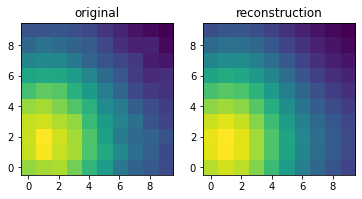

In [4]:
max_objects_smc = max_objects + 2
pad = 5
prior = CatalogPrior(max_objects_smc, img_width, img_height, pad, background_intensity/3.)
smc = SMCsampler(images[0], image_attributes, prior, num_blocks = max_objects_smc+1, catalogs_per_block = 500, max_smc_iters = 1000)

print(f"True count: {true_counts[0]}")
print(f"True total flux: {true_fluxes[0].sum()}\n")

smc.run(print_progress = True)
smc.summarize()